<a href="https://colab.research.google.com/github/davidfague/Model-Reduction-Methods/blob/main/NR_expand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Start
## The following code shows the main function that is used to reduce a complex cell.

complex_cell  # The model cell

synapses_list # A list of all synapse on this cell

netcon_list   # A list of all netcons for the synapses on the cell

import neuron_reduce

reduced_cell, synapses_list, netcons_list =  neuron_reduce.subtree_reductor(complex_cell, synapses_list, netcons_list)

# Detailed Example
## Example copied from github

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# !pip install neuron_reduce

In [3]:
!git clone https://github.com/orena1/neuron_reduce.git

fatal: destination path 'neuron_reduce' already exists and is not an empty directory.


In [4]:
# Go to example folder
%cd neuron_reduce 
%cd example
# compile the mod files
!nrnivmodl mod

/content/neuron_reduce
/content/neuron_reduce/example
/content/neuron_reduce/example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


### Neuron Reduce Functions for experimenting in notebook

reducing_methods.py

In [5]:
'''
This file contains the reduction algorithm itself
added the method by Guy to find L and X
'''
import collections
import contextlib
import logging
import math
import cmath

from neuron import h

logger = logging.getLogger(__name__)
CableParams = collections.namedtuple('CableParams',
                                     'length, diam, space_const,'
                                     'cm, rm, ra, e_pas, electrotonic_length')
SynapseLocation = collections.namedtuple('SynapseLocation', 'subtree_index, section_num, x')

h('''obfunc lowest_impedance_recursive() { local lowest_impedance, lowest_phase, i   localobj curr_subtree_root, sref1, lowest_imp_vec, lowest_child_subtree_impedance, imp_obj
    curr_subtree_root = $o1  // in the first call to the function, this is a root section of a dendritic trunk
    imp_obj = $o2
    curr_subtree_root.sec {
        lowest_impedance = imp_obj.transfer(1) // farthest tip of the the curr root section
        lowest_phase = imp_obj.transfer_phase(1)
    }

    if (curr_subtree_root.nchild != 0) { // if the curr section has child sections
        for i=0, curr_subtree_root.nchild-1 curr_subtree_root.child[i] {  // for each child of the root, finds the lowest impedance within the subtree whose root is the curr child (in relation to the proximal tip in the curr root child)
            curr_subtree_root.child[i] sref1 = new SectionRef()
            lowest_child_subtree_impedance = lowest_impedance_recursive(sref1, imp_obj) // recursively returns the lowest transfer impedance and transfer phase within the curr subtree as a vector
            if (lowest_child_subtree_impedance.x[0] < lowest_impedance) {
                lowest_impedance = lowest_child_subtree_impedance.x[0]
                lowest_phase = lowest_child_subtree_impedance.x[1]
            }
        }
    }
    lowest_imp_vec = new Vector(2)
    lowest_imp_vec.x[0] = lowest_impedance
    lowest_imp_vec.x[1] = lowest_phase
    return lowest_imp_vec
}''')


@contextlib.contextmanager
def push_section(section):
    '''push a section onto the top of the NEURON stack, pop it when leaving the context'''
    section.push()
    yield
    h.pop_section()


def _get_subtree_biophysical_properties(subtree_root_ref, frequency):
    ''' gets the biophysical cable properties (Rm, Ra, Rc) and q

    for the subtree to be reduced according to the properties of the root section of the subtree
    '''
    section = subtree_root_ref.sec

    rm = 1.0 / section.g_pas  # in ohm * cm^2
    # in secs, with conversion of the capacitance from uF/cm2 to F/cm2
    RC = rm * (float(section.cm) / 1000000)

    # defining q=sqrt(1+iwRC))
    angular_freq = 2 * math.pi * frequency   # = w
    q_imaginary = angular_freq * RC
    q = complex(1, q_imaginary)   # q=1+iwRC
    q = cmath.sqrt(q)		# q = sqrt(1+iwRC)

    return (section.cm,
            rm,
            section.Ra,  # in ohm * cm
            section.e_pas,
            q)


def find_lowest_subtree_impedance(subtree_root_ref, imp_obj):
    '''
    finds the segment in the subtree with the lowest transfer impedance in
    relation to the proximal-to-soma end of the given subtree root section,
    using a recursive hoc function,

    returns the lowest impedance in Ohms
    '''
    # returns [lowest subtree transfer impedance in Mohms, transfer phase]
    lowest_impedance = h.lowest_impedance_recursive(subtree_root_ref, imp_obj)
    # impedance saved as a complex number after converting Mohms to ohms
    curr_lowest_subtree_imp = cmath.rect(lowest_impedance.x[0] * 1000000, lowest_impedance.x[1])
    return curr_lowest_subtree_imp


def compute_zl_polar(Z0, L, q):
    '''
    given Z0 , L and q computes the polar represntation of ZL (equation 2.9 in Gals thesis)
    '''
    ZL = Z0 * 1.0 / cmath.cosh(q * L)
    ZL = cmath.polar(ZL)
    return ZL


def find_best_real_L(Z0, ZL_goal, q, max_L=10.0, max_depth=50):
    '''finds the best real L

    s.t. the modulus part of the impedance of ZL in eq 2.9 will be correct
    Since the modulus is a decreasing function of L, it is easy to find it using binary search.
    '''
    min_L = 0.0
    current_L = (min_L + max_L) / 2.0
    ZL_goal_A = cmath.polar(ZL_goal)[0]

    for _ in range(max_depth):
        Z_current_L_A = compute_zl_polar(Z0, current_L, q)[0]
        if abs(ZL_goal_A - Z_current_L_A) <= 0.001:  # Z are in Ohms , normal values are >10^6
            break
        elif ZL_goal_A > Z_current_L_A:
            current_L, max_L = (min_L + current_L) / 2.0, current_L
        else:
            current_L, min_L = (max_L + current_L) / 2.0, current_L
    else:
        logger.info("The difference between L and the goal L is larger than 0.001")
    return current_L


def compute_zx_polar(Z0, L, q, x):
    '''computes the polar represntation of Zx (equation 2.8 in Gals thesis)
    '''
    ZX = Z0 * cmath.cosh(q * (L - x)) / cmath.cosh(q * L)
    ZX = cmath.polar(ZX)
    return ZX


def find_best_real_X(Z0, ZX_goal, q, L, max_depth=50):
    '''finds the best location of a synapse (X)

    s.t. the modulus part of the impedance of ZX in eq 2.8 will be correct.
    Since the modulus is a decreasing function of L, it is easy to find it using binary search.
    '''
    min_x, max_x = 0.0, L
    current_x = (min_x + max_x) / 2.0

    ZX_goal = cmath.polar(ZX_goal)[0]

    for _ in range(max_depth):
        Z_current_X_A = compute_zx_polar(Z0, L, q, current_x)[0]

        if abs(ZX_goal - Z_current_X_A) <= 0.001:
            break
        elif ZX_goal > Z_current_X_A:
            current_x, max_x = (min_x + current_x) / 2.0, current_x
        else:
            current_x, min_x = (max_x + current_x) / 2.0, current_x
    else:
        logger.info("The difference between X and the goal X is larger than 0.001")

    return current_x


def find_subtree_new_electrotonic_length(root_input_impedance, lowest_subtree_impedance, q):
    ''' finds the subtree's reduced cable's electrotonic length

    based on the following equation:
    lowest_subtree_impedance = subtree_root_input_impedance/cosh(q*L)
    according to the given complex impedance values
    '''

    # this equation could be solved analytically using:
    # L = 1/q * arcosh(subtree_root_input_impedance/lowest_subtree_impedance),
    # But since L in this equation is complex number and we chose to focus on
    # finding the correct attenuation
    # we decided to search the L that will result with correct attenuation from
    # the tip of the dendrite to the soma.
    # We chose to use only real L (without a complex part)

    L = find_best_real_L(root_input_impedance, lowest_subtree_impedance, q)
    return L


def _find_subtree_new_diam_in_cm(root_input_impedance, electrotonic_length_as_complex, rm, ra, q):
    '''finds the subtree's new cable's diameter (in cm)

    according to the given complex input impedance at the segment in the
    original subtree that is closest to the soma (the tip), and the given cable
    electrotonic length,

    with the following equation:
    d (in cm) = (2/PI * (sqrt(RM*RA)/(q*subtree_root_input_impedance)) *
                 (coth(q * NewCableElectrotonicLength)) )^(2/3)
    derived from Rall's cable theory for dendrites (Gal Eliraz)
    '''

    diam_in_cm = (2.0 / math.pi *
                  (math.sqrt(rm * ra) / (q * root_input_impedance)) *
                  (1 / cmath.tanh(q * electrotonic_length_as_complex))  # coth = 1/tanh
                  ) ** (2.0 / 3)

    '''
    # for debugging inaccuracies:
    if diam_in_cm.imag != 0:
        if abs(diam_in_cm.imag) > 0.03:
        print "PROBLEM - DIAM HAS SUBSTANTIAL IMAGINARY PART"
        print "\n"
    '''

    # the radius of the complex number received from the equation
    new_subtree_dend_diam_in_cm = cmath.polar(diam_in_cm)[0]
    return new_subtree_dend_diam_in_cm


def find_space_const_in_cm(diameter, rm, ra):
    ''' returns space constant (lambda) in cm, according to: space_const = sqrt(rm/(ri+r0)) '''
    # rm = Rm/(PI * diam), diam is in cm and Rm is in ohm * cm^2
    rm = float(rm) / (math.pi * diameter)
    # ri = 4*Ra/ (PI * diam^2), diam is in cm and Ra is in ohm * cm
    ri = float(4 * ra) / (math.pi * (diameter**2))
    space_const = math.sqrt(rm / ri)  # r0 is negligible
    return space_const


def reduce_subtree(subtree_root, frequency):
    '''Reduces the subtree  from the original_cell into one single section (cable).

    The reduction is done by finding the length and diameter of the cable (a
    single solution) that preserves the subtree's input impedance at the
    somatic end, and the transfer impedance in the subtree from the distal end
    to the proximal somatic end (between the new cable's two tips).
    '''
######################################################################
    print(subtree_root)
##################
    subtree_root_ref = h.SectionRef(sec=subtree_root)
    cm, rm, ra, e_pas, q = _get_subtree_biophysical_properties(subtree_root_ref, frequency)

    # finds the subtree's input impedance (at the somatic-proximal end of the
    # subtree root section) and the lowest transfer impedance in the subtree in
    # relation to the somatic-proximal end (see more in Readme on NeuroReduce)
    imp_obj, root_input_impedance = measure_input_impedance_of_subtree(subtree_root, frequency)

    # in Ohms (a complex number)
    curr_lowest_subtree_imp = find_lowest_subtree_impedance(subtree_root_ref, imp_obj)

    # reducing the whole subtree into one section:
    # L = 1/q * arcosh(ZtreeIn(f)/min(ZtreeX,0(f)),
    # d = ( (2/pi * (sqrt(Rm*Ra)/q*ZtreeIn(f)) * coth(qL) )^(2/3) - from Gal Eliraz's thesis 1999
    new_cable_electrotonic_length = find_subtree_new_electrotonic_length(root_input_impedance,
                                                                         curr_lowest_subtree_imp,
                                                                         q)
    cable_electrotonic_length_as_complex = complex(new_cable_electrotonic_length, 0)
    new_cable_diameter_in_cm = _find_subtree_new_diam_in_cm(root_input_impedance,
                                                            cable_electrotonic_length_as_complex,
                                                            rm,
                                                            ra,
                                                            q)
    new_cable_diameter = new_cable_diameter_in_cm * 10000   # in microns

    # calculating the space constant, in order to find the cylinder's length:
    # space_const = sqrt(rm/(ri+r0))
    curr_space_const_in_cm = find_space_const_in_cm(new_cable_diameter_in_cm,
                                                    rm,
                                                    ra)
    curr_space_const_in_micron = 10000 * curr_space_const_in_cm
    new_cable_length = curr_space_const_in_micron * new_cable_electrotonic_length  # in microns

    return CableParams(length=new_cable_length,
                       diam=new_cable_diameter,
                       space_const=curr_space_const_in_micron,
                       cm=cm,
                       rm=rm,
                       ra=ra,
                       e_pas=e_pas,
                       electrotonic_length=new_cable_electrotonic_length)


def find_merged_loc(cable_nseg, relative_loc):
    '''
    Returns a synapse's merged relative location (x) on the cable, according to
    its given relative location on the cable and the given number of segments
    in the cable.

    The merged location is the relative location of the middle of the segment
    the synapse is in (or 0 or 1 if it is at one of the tips of the cable).
    '''

    if relative_loc in (0, 1):
        return relative_loc

    # finds the segment that the synapse is in, according to its relative
    # location and the num of segments in the cable (1 through nseg)
    mapped_segment_for_curr_syn = int(relative_loc * cable_nseg) + 1

    # location of middle of segment = the average between relative location of
    # end of segment and relative location of beginning of segment
    return ((float(mapped_segment_for_curr_syn) / cable_nseg) +
            (float(mapped_segment_for_curr_syn - 1) / cable_nseg)) / 2


def measure_input_impedance_of_subtree(subtree_root_section, frequency):
    '''measures the input impedance of the subtree with the given root section

    (at the "0" tip, the soma-proximal end),
    returns the Impedance hoc object and the input impedance as a complex value
    '''

    imp_obj = h.Impedance()
    CLOSE_TO_SOMA_EDGE = 0
    # sets origin for impedance calculations (soma-proximal end of root section)
    imp_obj.loc(CLOSE_TO_SOMA_EDGE, sec=subtree_root_section)

    # computes transfer impedance from every segment in the model in relation
    # to the origin location above
    imp_obj.compute(frequency + 1 / 9e9, 0)

    # in Ohms (impedance measured at soma-proximal end of root section)
    root_input_impedance = imp_obj.input(CLOSE_TO_SOMA_EDGE, sec=subtree_root_section) * 1000000
    root_input_phase = imp_obj.input_phase(CLOSE_TO_SOMA_EDGE, sec=subtree_root_section)
    # creates a complex impedance value out of the given polar coordinates
    root_input_impedance = cmath.rect(root_input_impedance, root_input_phase)
    return imp_obj, root_input_impedance


def reduce_synapse(cell_instance,
                   synapse_location,
                   on_basal,
                   imp_obj,
                   root_input_impedance,
                   new_cable_electrotonic_length,
                   q_subtree):
    '''
    Receives an instance of a cell, the location (section + relative
    location(x)) of a synapse to be reduced, a boolean on_basal that is True if
    the synapse is on a basal subtree, the number of segments in the reduced
    cable that this synapse is in, an Impedance calculating Hoc object, the
    input impedance at the root of this subtree, and the electrotonic length of
    the reduced cable that represents the current subtree
    (as a real and as a complex number) -
    and maps the given synapse to its new location on the reduced cable
    according to the NeuroReduce algorithm.  Returns the new "post-merging"
    relative location of the synapse on the reduced cable (x, 0<=x<=1), that
    represents the middle of the segment that this synapse is located at in the
    new reduced cable.
    '''
    # measures the original transfer impedance from the synapse to the
    # somatic-proximal end in the subtree root section
    if not on_basal:  # apical subtree
        section = cell_instance.apic[synapse_location.section_num]
    else:             # basal subtree
        section = cell_instance.dend[synapse_location.section_num]

    with push_section(section):
        orig_transfer_imp = imp_obj.transfer(synapse_location.x) * 1000000  # ohms
        orig_transfer_phase = imp_obj.transfer_phase(synapse_location.x)
        # creates a complex Impedance value with the given polar coordinates
        orig_synapse_transfer_impedance = cmath.rect(orig_transfer_imp, orig_transfer_phase)

    # synapse location could be calculated using:
    # X = L - (1/q) * arcosh( (Zx,0(f) / ZtreeIn(f)) * cosh(q*L) ),
    # derived from Rall's cable theory for dendrites (Gal Eliraz)
    # but we chose to find the X that will give the correct modulus. See comment about L values

    synapse_new_electrotonic_location = find_best_real_X(root_input_impedance,
                                                         orig_synapse_transfer_impedance,
                                                         q_subtree,
                                                         new_cable_electrotonic_length)
                                                         
    new_relative_loc_in_section = (float(synapse_new_electrotonic_location) /
                                   new_cable_electrotonic_length)

    if new_relative_loc_in_section > 1:  # PATCH
        new_relative_loc_in_section = 0.999999

    return new_relative_loc_in_section

subtree_reductor_func.py

In [6]:
'''
function subtree_reductor():
 which reduces a morphologically detailed cell instance into a morphologically
 simplified cell instance, according to NeuroReduce and merges synapses of the
 same type (same reverse potential, tau1, and tau2) that are mapped to the same
 segment. (see more in Readme on tool and usage)
 usage: For details, see comments in function
 outputs: reduced cell instance, a new synapses_list, and the netcons_list,
          which now corresponds to the new synapses.
- The model template file must have an init() function (see example in the
  attached model.hoc file) and the following public definitions specifying
  sections and section lists accordingly:
   public soma, dend, apic ; public all, somatic, apical, basal
- Supports numerous types of synapses (two synapses are considered to be of
  different types if they are different from each other in at least one of the
  following values: reverse potential, tau1, tau2)
'''
import collections
import itertools as it
import logging
import math
import re
import cmath

import numpy as np
import neuron
from neuron import h
h.load_file("stdrun.hoc")


logger = logging.getLogger(__name__)
SOMA_LABEL = "soma"
EXCLUDE_MECHANISMS = ('pas', 'na_ion', 'k_ion', 'ca_ion', 'h_ion', 'ttx_ion', )


def create_sections_in_hoc(type_of_section, num, instance_as_str):
    '''creates sections in the hoc world according to the given section type and number of sections
    in the instance whose name is given as a string
    '''
    h("strdef string")
    h.string = type_of_section
    h('{sprint(string, "create %s[%d]", string, ' + str(num) + ') }')
    h("{execute(string, " + instance_as_str + ")}")


def append_to_section_lists(section, type_of_sectionlist, instance_as_str):
    ''' appends given section to the sectionlist of the given type and to the "all" sectionlist
    in the hoc world in the instance whose name is given as a string
    '''
    h("strdef string")
    h.string = section + " " + type_of_sectionlist + ".append()"
    h("{execute(string, " + instance_as_str + ")}")
    h.string = section + " all.append()"
    h("{execute(string, " + instance_as_str + ")}")


def find_section_number(section):
    ''' extracts and returns the section number from the given section object '''
    sec_name = h.secname(sec=section)
    ints_in_name = re.findall(r'\d+', sec_name)
    sec_num = ints_in_name[len(ints_in_name) - 1]  # extracts section number
    return sec_num


def calculate_nsegs_from_manual_arg(new_cable_properties, total_segments_wanted):
    '''Calculates the number of segments for each section in the reduced model
    according to the given total_segments_wanted and the given
    new_dends_electrotonic_length (the electrotonic lengths of all the new
    sections).  Called when the user chooses to give to the program the
    approximate total number of segments that the reduced model should have
    (non-default calculation).
    '''
    # minus one for the one segment of the soma:
    total_segments_in_dendrites = total_segments_wanted - 1

    # total electrotonic length of reduced dendritic cables
    sum_of_lengths = sum(prop.electrotonic_length
                         for prop in new_cable_properties)

    # the num of segments assigned to each section is in proportion to the
    # section's relative contribution to the total electrotonic length in the
    # model
    dends_nsegs = []
    for prop in new_cable_properties:
        new_length = prop.electrotonic_length
        new_nseg_to_put = int(round((float(new_length) / sum_of_lengths) *
                              total_segments_in_dendrites))
        if new_nseg_to_put < 1:
            new_nseg_to_put = 1
        dends_nsegs.append(new_nseg_to_put)
    return dends_nsegs


def calculate_nsegs_from_lambda(new_cable_properties):
    '''calculate the number of segments for each section in the reduced model
    according to the length (in microns) and space constant (= lambda - in
    microns) that were previously calculated for each section and are given in
    subtree_dimensions.  According to this calculation, a segment is formed for
    every 0.1 * lambda in a section. (lambda = space constant = electrotonic length unit).
    '''
    dends_nsegs = []
    for cable in new_cable_properties:
        # for every unit of electronic length (length/space_constant such units)
        # ~10 segments are formed
        dends_nsegs.append(int((float(cable.length) / cable.space_const) * 10 / 2) * 2 + 1)
    return dends_nsegs


def mark_subtree_sections_with_subtree_index(sections_to_delete,
                                             section_per_subtree_index,
                                             root_sec_of_subtree,
                                             mapping_sections_to_subtree_index,
                                             section_type,
                                             subtree_index):
    '''Recursively marks all sections in the subtree as belonging to the given subtree_index
    using the given dict mapping_sections_to_subtree_index, as follows:
    mapping_sections_to_subtree_index[(<section_type>, <section_number>)] = given subtree_index
    '''
    sections_to_delete.append(root_sec_of_subtree)
    section_per_subtree_index.setdefault(subtree_index, [])
    section_per_subtree_index[subtree_index].append(root_sec_of_subtree)

    section_num = find_section_number(root_sec_of_subtree)

    for child in root_sec_of_subtree.children():
        mark_subtree_sections_with_subtree_index(sections_to_delete,
                                                 section_per_subtree_index,
                                                 child,
                                                 mapping_sections_to_subtree_index,
                                                 section_type,
                                                 subtree_index)
    mapping_sections_to_subtree_index[(section_type, section_num)] = subtree_index


def find_synapse_loc(synapse_or_segment, mapping_sections_to_subtree_index):
    ''' Returns the location  of the given synapse object'''

    if not isinstance(synapse_or_segment, neuron.nrn.Segment):
        synapse_or_segment = synapse_or_segment.get_segment()

    x = synapse_or_segment.x

    with push_section(synapse_or_segment.sec):
        # extracts the section type ("soma", "apic", "dend") and the section number
        # out of the section name
        full_sec_name = h.secname()
        sec_name_as_list = full_sec_name.split(".")
        short_sec_name = sec_name_as_list[len(sec_name_as_list) - 1]
        section_type = short_sec_name.split("[")[0]
        section_num = re.findall(r'\d+', short_sec_name)[0]

    # finds the index of the subtree that this synapse belongs to using the
    # given mapping_sections_to_subtree_index which maps sections to the
    # subtree indexes that they belong to
    if section_type == "apic":
        subtree_index = mapping_sections_to_subtree_index[("apic", section_num)]
    elif section_type == "dend":
        subtree_index = mapping_sections_to_subtree_index[("basal", section_num)]
    else:  # somatic synapse
        subtree_index, section_num, x = SOMA_LABEL, 0, 0

    return SynapseLocation(subtree_index, int(section_num), x)


def find_and_disconnect_axon(soma_ref):
    '''Searching for an axon, it can be a child of the soma or a parent of the soma.'''
    axon_section, axon_parent, soma_axon_x  = [], False, None

    for sec in soma_ref.child:
        name = sec.hname().lower()
        if 'axon' in name or 'hill' in name:
            axon_section.append(sec)
            # disconnect axon
            soma_axon_x = sec.parentseg().x
            sec.push()
            h.disconnect()
            h.define_shape()

    if soma_ref.has_parent():
        name = soma_ref.parent().sec.hname().lower()
        if 'axon' in name or 'hill' in name:
            axon_section.append(soma_ref.parent())
            axon_parent = True
            soma_axon_x = None
            soma_ref.push()
            h.disconnect()
        else:
            raise Exception('Soma has a parent which is not an axon')

    if len(axon_section) > 1:
        raise Exception('Soma has a two axons')

    return axon_section, axon_parent, soma_axon_x


def create_segments_to_mech_vals(sections_to_delete,
                                 remove_mechs=True,
                                 exclude=EXCLUDE_MECHANISMS):
    '''This function copy the create a mapping between a dictionary and the mechanisms that it have
       plus the values of those mechanisms. It also remove the mechanisms from the model in order to
       create a passive model
       Arguments:
           remove_mechs - False|True
               if True remove the mechs after creating the mapping, False - keep the mechs
           exclude - List of all the mechs name that should not be removed
       '''
    exclude = set(exclude)
    segment_to_mech_vals, mech_names = {}, set()
    for seg in it.chain.from_iterable(sections_to_delete):
        segment_to_mech_vals[seg] = {}
        for mech in seg:
            mech_name = mech.name()
            segment_to_mech_vals[seg][mech_name] = {}
            for n in dir(mech):
                if n.startswith('__') or n in ('next', 'name', 'is_ion', 'segment', ):
                    continue

                if not n.endswith('_' + mech_name) and not mech_name.endswith('_ion'):
                    n += '_' + mech_name

                segment_to_mech_vals[seg][mech_name][n] = getattr(seg, n)
                mech_names.add(mech_name)

    mech_names -= exclude

    if remove_mechs:  # Remove all the mechs from the sections
        for sec in sections_to_delete:
            with push_section(sec):
                for mech in mech_names:
                    h("uninsert " + mech)

    return segment_to_mech_vals


def create_seg_to_seg(original_cell,
                      section_per_subtree_index,
                      roots_of_subtrees,
                      mapping_sections_to_subtree_index,
                      new_cable_properties,
                      has_apical,
                      apic,
                      basals,
                      subtree_ind_to_q,
                      mapping_type,
                      reduction_frequency):
    '''create mapping between segments in the original model to segments in the reduced model
       if mapping_type == impedance the mapping will be a response to the
       transfer impedance of each segment to the soma (like the synapses)
       if mapping_type == distance  the mapping will be a response to the
       distance of each segment to the soma (like the synapses) NOT IMPLEMENTED
       YET
       '''

    assert mapping_type == 'impedance', 'distance mapping not implemented yet'
    # the keys are the segments of the original model, the values are the
    # segments of the reduced model
    original_seg_to_reduced_seg = {}
    reduced_seg_to_original_seg = collections.defaultdict(list)
    for subtree_index in section_per_subtree_index:
        for sec in section_per_subtree_index[subtree_index]:
            for seg in sec:
                synapse_location = find_synapse_loc(seg, mapping_sections_to_subtree_index)
                imp_obj, subtree_input_impedance = measure_input_impedance_of_subtree(
                    roots_of_subtrees[subtree_index], reduction_frequency)

                # if synapse is on the apical subtree
                on_basal_subtree = not (has_apical and subtree_index == 0)

                mid_of_segment_loc = reduce_synapse(
                    original_cell,
                    synapse_location,
                    on_basal_subtree,
                    imp_obj,
                    subtree_input_impedance,
                    new_cable_properties[subtree_index].electrotonic_length,
                    subtree_ind_to_q[subtree_index])

                if on_basal_subtree:
                    if has_apical:
                        new_section_for_synapse = basals[subtree_index - 1]
                    else:
                        new_section_for_synapse = basals[subtree_index]
                else:
                    new_section_for_synapse = apic

                reduced_seg = new_section_for_synapse(mid_of_segment_loc)
                original_seg_to_reduced_seg[seg] = reduced_seg
                reduced_seg_to_original_seg[reduced_seg].append(seg)

    return original_seg_to_reduced_seg, dict(reduced_seg_to_original_seg)


def copy_dendritic_mech(original_seg_to_reduced_seg,
                        reduced_seg_to_original_seg,
                        apic,
                        basals,
                        segment_to_mech_vals,
                        mapping_type='impedance'):
    ''' copies the mechanisms from the original model to the reduced model'''

    # copy mechanisms
    # this is needed for the case where some segements were not been mapped
    mech_names_per_segment = collections.defaultdict(list)
    vals_per_mech_per_segment = {}
    for reduced_seg, original_segs in reduced_seg_to_original_seg.items():
        vals_per_mech_per_segment[reduced_seg] = collections.defaultdict(list)

        for original_seg in original_segs:
            for mech_name, mech_params in segment_to_mech_vals[original_seg].items():
                for param_name, param_value in mech_params.items():
                    vals_per_mech_per_segment[reduced_seg][param_name].append(param_value)

                mech_names_per_segment[reduced_seg].append(mech_name)
                reduced_seg.sec.insert(mech_name)

        for param_name, param_values in vals_per_mech_per_segment[reduced_seg].items():
            setattr(reduced_seg, param_name, np.mean(param_values))

    all_segments = []
    if apic is not None:
        all_segments.extend(list(apic))

    for bas in basals:
        all_segments.extend(list(bas))

    if len(all_segments) != len(reduced_seg_to_original_seg):
        logger.warning('There is no segment to segment copy, it means that some segments in the'
                    'reduced model did not receive channels from the original cell.'
                    'Trying to compensate by copying channels from neighboring segments')
        handle_orphan_segments(original_seg_to_reduced_seg,
                               all_segments,
                               vals_per_mech_per_segment,
                               mech_names_per_segment)


def handle_orphan_segments(original_seg_to_reduced_seg,
                           all_segments,
                           vals_per_mech_per_segment,
                           mech_names_per_segment):
    ''' This function handle reduced segments that did not had original segments mapped to them'''
    # Get all reduced segments that have been mapped by a original model segment
    all_mapped_control_segments = original_seg_to_reduced_seg.values()
    non_mapped_segments = set(all_segments) - set(all_mapped_control_segments)

    for reduced_seg in non_mapped_segments:
        seg_secs = list(reduced_seg.sec)
        # find valid parent
        parent_seg_index = seg_secs.index(reduced_seg) - 1
        parent_seg = None
        while parent_seg_index > -1:
            if seg_secs[parent_seg_index] in all_mapped_control_segments:
                parent_seg = seg_secs[parent_seg_index]
                break
            else:
                parent_seg_index -= 1

        # find valid child
        child_seg_index = seg_secs.index(reduced_seg) + 1
        child_seg = None
        while child_seg_index < len(seg_secs):
            if seg_secs[child_seg_index] in all_mapped_control_segments:
                child_seg = seg_secs[child_seg_index]
                break
            else:
                child_seg_index += 1

        if not parent_seg and not child_seg:
            raise Exception("no child seg nor parent seg, with active channels, was found")

        if parent_seg and not child_seg:
            for mech in mech_names_per_segment[parent_seg]:
                reduced_seg.sec.insert(mech)
            for n in vals_per_mech_per_segment[parent_seg]:
                setattr(reduced_seg, n, np.mean(vals_per_mech_per_segment[parent_seg][n]))

        if not parent_seg and child_seg:
            for mech in mech_names_per_segment[child_seg]:
                reduced_seg.sec.insert(mech)
            for n in vals_per_mech_per_segment[child_seg]:
                setattr(reduced_seg, n, np.mean(vals_per_mech_per_segment[child_seg][n]))

        # if both parent and child were found, we add to the segment all the mech in both
        # this is just a decision

        if parent_seg and child_seg:
            for mech in set(mech_names_per_segment[child_seg]) & set(mech_names_per_segment[parent_seg]):
                reduced_seg.sec.insert(mech)

            for n in vals_per_mech_per_segment[child_seg]:
                child_mean = np.mean(vals_per_mech_per_segment[child_seg][n])
                if n in vals_per_mech_per_segment[parent_seg]:
                    parent_mean = np.mean(vals_per_mech_per_segment[parent_seg][n])
                    setattr(reduced_seg, n, (child_mean + parent_mean) / 2)
                else:
                    setattr(reduced_seg, n, child_mean)

            for n in vals_per_mech_per_segment[parent_seg]:
                parent_mean = np.mean(vals_per_mech_per_segment[parent_seg][n])
                if n in vals_per_mech_per_segment[child_seg]:
                    child_mean = np.mean(vals_per_mech_per_segment[child_seg][n])
                    setattr(reduced_seg, n, (child_mean + parent_mean) / 2)
                else:
                    setattr(reduced_seg, n, parent_mean)


def add_PP_properties_to_dict(PP, PP_params_dict):
    '''
    add the propeties of a point process to PP_params_dict.
    The only propeties added to the dictionary are those worth comparing
    '''
    skipped_params = {"Section", "allsec", "baseattr", "cas", "g", "get_loc", "has_loc", "hname",
                      'hocobjptr', "i", "loc", "next", "ref", "same", "setpointer", "state",
                      "get_segment",
                      }
    PP_params = []
    for param in dir(PP):
        if param.startswith("__") or param in skipped_params:
            continue
        PP_params.append(param)
    PP_params_dict[type_of_point_process(PP)] = PP_params


def type_of_point_process(PP):
    s = PP.hname()
    ix = PP.hname().find("[")
    return s[:ix]


def apply_params_to_section(name, type_of_sectionlist, instance_as_str, section, cable_params, nseg):
    section.L = cable_params.length
    section.diam = cable_params.diam
    section.nseg = nseg

    append_to_section_lists(name, type_of_sectionlist, instance_as_str)

    section.insert('pas')
    section.cm = cable_params.cm
    section.g_pas = 1.0 / cable_params.rm
    section.Ra = cable_params.ra
    section.e_pas = cable_params.e_pas


def calculate_subtree_q(root, reduction_frequency):
    rm = 1.0 / root.g_pas
    rc = rm * (float(root.cm) / 1000000)
    angular_freq = 2 * math.pi * reduction_frequency
    q_imaginary = angular_freq * rc
    q_subtree = complex(1, q_imaginary)   # q=1+iwRC
    q_subtree = cmath.sqrt(q_subtree)
    return q_subtree


def synapse_properties_match(synapse, PP, PP_params_dict):
    if PP.hname()[:PP.hname().rindex('[')] != synapse.hname()[:synapse.hname().rindex('[')]:
        return False
    for param in PP_params_dict[type_of_point_process(PP)]:
        if(param not in ['rng'] and  # https://github.com/neuronsimulator/nrn/issues/136
           str(type(getattr(PP, param))) != "<type 'hoc.HocObject'>" and  # ignore hoc objects
           getattr(PP, param) != getattr(synapse, param)):
            return False
    return True


def load_model(model_filename):
    model_obj_name = model_filename.split(".")[0].split('/')[-1]
    if h.name_declared(model_obj_name) == 0:
        logger.debug("loading template '%s'" % model_obj_name)
        if model_filename == 'model.hoc':
            logger.debug("loading default reduced model")
            load_default_model()
        else:
            h.load_file(model_filename)
    else:
        logger.info("The template '%s' is already defined... not loading." % model_obj_name)
    return model_obj_name


def gather_subtrees(soma_ref):
    '''get all the subtrees of the soma
    assumes the axon is already disconnected
    return (list(roots_of_subtrees), list(num_of_subtrees))
    where:
      roots_of_subtrees holds the root sections of each of the soma's subtrees
        note: The apical, if it exists, has been moved to the front
      num_of_subtrees correctly the number of subtrees, excluding the axon
    '''

    roots_of_subtrees = []
    num_of_subtrees = []
    for i in range(int(soma_ref.nchild())):
        if 'soma' in str(soma_ref.child[i]):
            logger.warning("soma is child, ignore - not tested yet")
            continue
        num_of_subtrees.append(i)
        roots_of_subtrees.append(soma_ref.child[i])

    # assuming up to one apical tree
    ix_of_apical = None
    for i in num_of_subtrees:
        if 'apic' in roots_of_subtrees[i].hname():
            assert ix_of_apical is None, 'Multiple apical dendrites not supported'
            ix_of_apical = i

    if ix_of_apical is not None:
        roots_of_subtrees = ([roots_of_subtrees[ix_of_apical]] +
                             roots_of_subtrees[:ix_of_apical] +
                             roots_of_subtrees[ix_of_apical + 1:])
    return roots_of_subtrees, num_of_subtrees


def gather_cell_subtrees(roots_of_subtrees):
    # dict that maps section indexes to the subtree index they are in: keys are
    # string tuples: ("apic"/"basal", orig_section_index) , values are ints:
    # subtree_instance_index
    sections_to_delete = []
    section_per_subtree_index = {}
    mapping_sections_to_subtree_index = {}
    for i, soma_child in enumerate(roots_of_subtrees):
        # inserts each section in this subtree into the above dict, which maps
        # it to the subtree index
        if 'apic' in soma_child.hname():
            assert i == 0, ('The apical is not the first child of the soma! '
                            'a code refactoring is needed in order to accept it')
            mark_subtree_sections_with_subtree_index(sections_to_delete,
                                                     section_per_subtree_index,
                                                     soma_child,
                                                     mapping_sections_to_subtree_index,
                                                     "apic",
                                                     i)
        elif 'dend' in soma_child.hname() or 'basal' in soma_child.hname():
            mark_subtree_sections_with_subtree_index(sections_to_delete,
                                                     section_per_subtree_index,
                                                     soma_child,
                                                     mapping_sections_to_subtree_index,
                                                     "basal",
                                                     i)

    return sections_to_delete, section_per_subtree_index, mapping_sections_to_subtree_index


def create_reduced_cell(soma_cable,
                        has_apical,
                        original_cell,
                        model_obj_name,
                        new_cable_properties,
                        new_cables_nsegs,
                        subtrees_xs):
    h("objref reduced_cell")
    h("reduced_cell = new " + model_obj_name + "()")

    create_sections_in_hoc("soma", 1, "reduced_cell")

    soma = original_cell.soma[0] if original_cell.soma.hname()[-1] == ']' else original_cell.soma
    append_to_section_lists("soma[0]", "somatic", "reduced_cell")

    if has_apical:  # creates reduced apical cable if apical subtree existed
        create_sections_in_hoc("apic", 1, "reduced_cell")
        apic = h.reduced_cell.apic[0]
        num_of_basal_subtrees = len(new_cable_properties) - 1

        cable_params = new_cable_properties[0]
        nseg = new_cables_nsegs[0]
        apply_params_to_section("apic[0]", "apical", "reduced_cell",
                                apic, cable_params, nseg)
        apic.connect(soma, subtrees_xs[0], 0)
    else:
        apic = None
        num_of_basal_subtrees = len(new_cable_properties)

    # creates reduced basal cables
    create_sections_in_hoc("dend", num_of_basal_subtrees, "reduced_cell")
    basals = [h.reduced_cell.dend[i] for i in range(num_of_basal_subtrees)]

    for i in range(num_of_basal_subtrees):
        if has_apical:
            index_in_reduced_cables_dimensions = i + 1
        else:
            index_in_reduced_cables_dimensions = i

        cable_params = new_cable_properties[index_in_reduced_cables_dimensions]
        nseg = new_cables_nsegs[index_in_reduced_cables_dimensions]

        apply_params_to_section("dend[" + str(i) + "]", "basal", "reduced_cell",
                                basals[i], cable_params, nseg)

        basals[i].connect(soma, subtrees_xs[index_in_reduced_cables_dimensions], 0)

    # create cell python template
    cell = Neuron(h.reduced_cell)
    cell.soma = original_cell.soma
    cell.apic = apic

    return cell, basals


def merge_and_add_synapses(num_of_subtrees,
                           new_cable_properties,
                           PP_params_dict,
                           synapses_list,
                           mapping_sections_to_subtree_index,
                           netcons_list,
                           has_apical,
                           roots_of_subtrees,
                           original_cell,
                           basals,
                           cell,
                           reduction_frequency):
    # dividing the original synapses into baskets, so that all synapses that are
    # on the same subtree will be together in the same basket

    # a list of baskets of synapses, each basket in the list will hold the
    # synapses of the subtree of the corresponding basket index
    baskets = [[] for _ in num_of_subtrees]
    soma_synapses_syn_to_netcon = {}

    for syn_index, synapse in enumerate(synapses_list):
        synapse_location = find_synapse_loc(synapse, mapping_sections_to_subtree_index)

        # for a somatic synapse
        # TODO: 'axon' is never returned by find_synapse_loc...
        if synapse_location.subtree_index in (SOMA_LABEL, 'axon'):
            soma_synapses_syn_to_netcon[synapse] = netcons_list[syn_index]
        else:
            baskets[synapse_location.subtree_index].append((synapse, synapse_location, syn_index))

    # mapping (non-somatic) synapses to their new location on the reduced model
    # (the new location is the exact location of the middle of the segment they
    # were mapped to, in order to enable merging)
    new_synapses_list, subtree_ind_to_q = [], {}
    for subtree_index in num_of_subtrees:
        imp_obj, subtree_input_impedance = measure_input_impedance_of_subtree(
            roots_of_subtrees[subtree_index], reduction_frequency)
        subtree_ind_to_q[subtree_index] = calculate_subtree_q(
            roots_of_subtrees[subtree_index], reduction_frequency)

        # iterates over the synapses in the curr basket
        for synapse, synapse_location, syn_index in baskets[subtree_index]:
            on_basal_subtree = not (has_apical and subtree_index == 0)

            # "reduces" the synapse - finds this synapse's new "merged"
            # location on its corresponding reduced cable
            x = reduce_synapse(original_cell,
                               synapse_location,
                               on_basal_subtree,
                               imp_obj,
                               subtree_input_impedance,
                               new_cable_properties[subtree_index].electrotonic_length,
                               subtree_ind_to_q[subtree_index])

            # find the section of the synapse
            if on_basal_subtree:
                if has_apical:
                    section_for_synapse = basals[subtree_index - 1]
                else:
                    section_for_synapse = basals[subtree_index]
            else:
                section_for_synapse = cell.apic

            # go over all point processes in this segment and see whether one
            # of them has the same proporties of this synapse
            # If there's such a synapse link the original NetCon with this point processes
            # If not, move the synapse to this segment.
            for PP in section_for_synapse(x).point_processes():
                if type_of_point_process(PP) not in PP_params_dict:
                    add_PP_properties_to_dict(PP, PP_params_dict)

                if synapse_properties_match(synapse, PP, PP_params_dict):
                    netcons_list[syn_index].setpost(PP)
                    break
            else:  # If for finish the loop -> first appearance of this synapse
                synapse.loc(x, sec=section_for_synapse)
                new_synapses_list.append(synapse)

    # merging somatic and axonal synapses
    synapses_per_seg = collections.defaultdict(list)
    for synapse in soma_synapses_syn_to_netcon:
        seg_pointer = synapse.get_segment()

        for PP in synapses_per_seg[seg_pointer]:
            if type_of_point_process(PP) not in PP_params_dict:
                add_PP_properties_to_dict(PP, PP_params_dict)

            if synapse_properties_match(synapse, PP, PP_params_dict):
                soma_synapses_syn_to_netcon[synapse].setpost(PP)
                break
        else:  # If for finish the loop -> first appearance of this synapse
            synapse.loc(seg_pointer.x, sec=seg_pointer.sec)
            new_synapses_list.append(synapse)
            synapses_per_seg[seg_pointer].append(synapse)

    return new_synapses_list, subtree_ind_to_q

def textify_seg_to_seg(segs):
    '''convert segment dictionary to text'''
    ret = {str(k): str(v) for k, v in segs.items()}
    return ret
   
def subtree_reductor(original_cell,
                     synapses_list,
                     netcons_list,
                     reduction_frequency,
                     model_filename='model.hoc',
                     total_segments_manual=-1,
                     PP_params_dict=None,
                     mapping_type='impedance',
                     return_seg_to_seg=False
                     ):

    '''
    Receives an instance of a cell with a loaded full morphology, a list of
    synapse objects, a list of NetCon objects (the i'th netcon in the list
    should correspond to the i'th synapse), the filename (string) of the model
    template hoc file that the cell was instantiated from, the desired
    reduction frequency as a float, optional parameter for the approximate
    desired number of segments in the new model (if this parameter is empty,
    the number of segments will be such that there is a segment for every 0.1
    lambda), and an optional param for the point process to be compared before
    deciding on whether to merge a synapse or not and reduces the cell (using
    the given reduction_frequency). Creates a reduced instance using the model
    template in the file whose filename is given as a parameter, and merges
    synapses of the same type that get mapped to the same segment
    (same "reduced" synapse object for them all, but different NetCon objects).
    model_filename : model.hoc  will use a default template
    total_segments_manual: sets the number of segments in the reduced model
                           can be either -1, a float between 0 to 1, or an int
                           if total_segments_manual = -1 will do automatic segmentation
                           if total_segments_manual>1 will set the number of segments
                           in the reduced model to total_segments_manual
                           if 0>total_segments_manual>1 will automatically segment the model
                           but if the automatic segmentation will produce a segment number that
                           is lower than original_number_of_segments*total_segments_manual it
                           will set the number of segments in the reduced model to:
                           original_number_of_segments*total_segments_manual
    return_seg_to_seg: if True the function will also return a textify version of the mapping
                       between the original segments to the reduced segments 
    Returns the new reduced cell, a list of the new synapses, and the list of
    the inputted netcons which now have connections with the new synapses.
    Notes:
    1) The original cell instance, synapses and Netcons given as arguments are altered
    by the function and cannot be used outside of it in their original context.
    2) Synapses are determined to be of the same type and mergeable if their reverse
    potential, tau1 and tau2 values are identical.
    3) Merged synapses are assigned a single new synapse object that represents them
    all, but keep their original NetCon objects. Each such NetCon now connects the
    original synapse's NetStim with
    the reduced synapse.
    '''
    if PP_params_dict is None:
        PP_params_dict = {}

    h.init()

    model_obj_name = load_model(model_filename)

    # finds soma properties
    soma = original_cell.soma[0] if original_cell.soma.hname()[-1] == ']' else original_cell.soma

    soma_cable = CableParams(length=soma.L, diam=soma.diam, space_const=None,
                             cm=soma.cm, rm=1.0 / soma.g_pas, ra=soma.Ra, e_pas=soma.e_pas,
                             electrotonic_length=None)

    has_apical = len(list(original_cell.apical)) != 0

    soma_ref = h.SectionRef(sec=soma)
    axon_section, axon_is_parent, soma_axon_x = find_and_disconnect_axon(soma_ref)
    roots_of_subtrees, num_of_subtrees = gather_subtrees(soma_ref)

    sections_to_delete, section_per_subtree_index, mapping_sections_to_subtree_index = \
        gather_cell_subtrees(roots_of_subtrees)

    # preparing for reduction

    # remove active conductances and get seg_to_mech dictionary
    segment_to_mech_vals = create_segments_to_mech_vals(sections_to_delete)

    # disconnects all the subtrees from the soma
    subtrees_xs = []
    for subtree_root in roots_of_subtrees:
        subtrees_xs.append(subtree_root.parentseg().x)
        h.disconnect(sec=subtree_root)

    # reducing the subtrees
    new_cable_properties = [reduce_subtree(roots_of_subtrees[i], reduction_frequency)
                            for i in num_of_subtrees]

    if total_segments_manual > 1:
        new_cables_nsegs = calculate_nsegs_from_manual_arg(new_cable_properties,
                                                           total_segments_manual)
    else:
        new_cables_nsegs = calculate_nsegs_from_lambda(new_cable_properties)
        if total_segments_manual > 0:
            original_cell_seg_n = (sum(i.nseg for i in list(original_cell.basal)) +
                                   sum(i.nseg for i in list(original_cell.apical))
                                   )
            min_reduced_seg_n = int(round((total_segments_manual * original_cell_seg_n)))
            if sum(new_cables_nsegs) < min_reduced_seg_n:
                logger.debug("number of segments calculated using lambda is {}, "
                      "the original cell had {} segments.  "
                      "The min reduced segments is set to {}% of reduced cell segments".format(
                          sum(new_cables_nsegs),
                          original_cell_seg_n,
                          total_segments_manual * 100))
                logger.debug("the reduced cell nseg is set to %s" % min_reduced_seg_n)
                new_cables_nsegs = calculate_nsegs_from_manual_arg(new_cable_properties,
                                                                   min_reduced_seg_n)

    cell, basals = create_reduced_cell(soma_cable,
                                       has_apical,
                                       original_cell,
                                       model_obj_name,
                                       new_cable_properties,
                                       new_cables_nsegs,
                                       subtrees_xs)

    new_synapses_list, subtree_ind_to_q = merge_and_add_synapses(
        num_of_subtrees,
        new_cable_properties,
        PP_params_dict,
        synapses_list,
        mapping_sections_to_subtree_index,
        netcons_list,
        has_apical,
        roots_of_subtrees,
        original_cell,
        basals,
        cell,
        reduction_frequency)

    # create segment to segment mapping
    original_seg_to_reduced_seg, reduced_seg_to_original_seg = create_seg_to_seg(
        original_cell,
        section_per_subtree_index,
        roots_of_subtrees,
        mapping_sections_to_subtree_index,
        new_cable_properties,
        has_apical,
        cell.apic,
        basals,
        subtree_ind_to_q,
        mapping_type,
        reduction_frequency)

    # copy active mechanisms
    copy_dendritic_mech(original_seg_to_reduced_seg,
                        reduced_seg_to_original_seg,
                        cell.apic,
                        basals,
                        segment_to_mech_vals,
                        mapping_type)
    
    if return_seg_to_seg:
        original_seg_to_reduced_seg_text = textify_seg_to_seg(original_seg_to_reduced_seg)

    # Connect axon back to the soma
    if len(axon_section) > 0:
        if axon_is_parent:
            soma.connect(axon_section[0])
        else:
            axon_section[0].connect(soma, soma_axon_x)

    # Now we delete the original model
    for section in sections_to_delete:
        with push_section(section):
            h.delete_section()

    cell.axon = axon_section
    cell.dend = cell.hoc_model.dend

    with push_section(cell.hoc_model.soma[0]):
        h.delete_section()
    if return_seg_to_seg:
        return cell, new_synapses_list, netcons_list, original_seg_to_reduced_seg_text
    else:
        return cell, new_synapses_list, netcons_list


class Neuron(object):
    'Python neuron class for hoc models'
    def __init__(self, model):
        self.hoc_model = model
        self.soma = None
        self.dend = None
        self.apic = None
        self.axon = None


def load_default_model():
    h('''begintemplate model
public init, biophys, geom_nseg, delete_axon, finish_creating_model_after_loading_morphology
public soma, dend, apic, axon  // sections
public all, somatic, apical, axonal, basal // section lists
objref all, somatic, apical, axonal, basal, this
proc init() {
    all = new SectionList()
    somatic = new SectionList()
    basal = new SectionList()
    apical = new SectionList()
    axonal = new SectionList()
    forall delete_section()
    StepDist = 60 // human cells have no spines in their first 60 um
                                // from soma - see Benavides-Piccione 2013
    F_Spines = 1.9       //As calculated - see detailes in Eyal 2015
    CM =0.45	// uF/cm2
    RM = 38907
    RA = 203
    E_PAS =  -86
}
create soma[1], dend[1], apic[1], axon[1]
//external lambda_f
proc geom_nseg() {
    soma distance()
    forsec all {
        RA_calc = RA
        RM_calc = RM*F_Spines
        if (distance(1)>StepDist){
            RA_calc = RA
            RM_calc = RM*F_Spines
        }
        d = diam
        lambda = sqrt(RM_calc/RA_calc*d/10000/4)*10000
        nseg = int(L/lambda*10/2)*2+1
    }
}
proc biophys() {
    forsec all {
        insert pas
        cm =CM
        g_pas=1/RM
        Ra = RA
        e_pas = E_PAS
    }
    soma distance()
    forsec basal {
        if (distance(0.5)>StepDist) {
            L = L*F_Spines^(2/3)
            diam = diam*(F_Spines^(1/3))
        }
    }
    forsec apical {
        if (distance(0.5)>StepDist) {
            L = L*F_Spines^(2/3)
            diam = diam*(F_Spines^(1/3))
        }
    }
}
proc delete_axon(){
    forsec axonal{delete_section()}
}
proc complete_full_model_creation() {
    geom_nseg()      		             // calculates num of segments
    delete_axon()		                     // deletes the axon
    biophys()			             // increases cell dimensions to account for spines
}
endtemplate model''')

tree_expander.py

In [7]:
#code for cable_expander.py
'''
Choose Branching point #Find apical branching segment in complex cell and choose the corresponding reduced segment using NR dictionary - have not automated this
Complex: 'L5PCtemplate[0].apic[36](0.961538)' to reduced: ‘model[0].apic[0](0.289004)’
The branching segment is at x=0.289004; section length: model[0].apic[0].L =2424.182421257107
#Get desired trunk length from chosen branching point
Trunk Length = x*L=0.289004*2424.182421257107=700
'''
#Get all other trunk cable properties by copying cylinder properties (this excludes mechanisms and synapses)

#Adjust any trunk cable properties that are range variables (such as diameter) so that the range goes from rangevar(var(0),var(branching point)) instead of rangevar(var(0),var(1))
#Get branch cable properties:
	
#	Diameter: Rall’s D3/2 rule
#Spatial Length: preserve maximum range of transfer impedance to soma or preserve surface area from replaced cylinder
#Ra- same as trunk
#…
#Collect mechanisms and synapses  from segments before (~trunk) and after (~branches) chosen branching point.
#Delete apical cylinder
#Build trunk, branches


"\nChoose Branching point #Find apical branching segment in complex cell and choose the corresponding reduced segment using NR dictionary - have not automated this\nComplex: 'L5PCtemplate[0].apic[36](0.961538)' to reduced: ‘model[0].apic[0](0.289004)’\nThe branching segment is at x=0.289004; section length: model[0].apic[0].L =2424.182421257107\n#Get desired trunk length from chosen branching point\nTrunk Length = x*L=0.289004*2424.182421257107=700\n"

In [8]:
#testing area for functions


##Define The Cell

In [9]:
#Run the code
from __future__ import division
from neuron import gui,h
import numpy as np
import neuron_reduce
import time
import matplotlib.pyplot as plt

#Create a L5_PC model
h.load_file('L5PCbiophys3.hoc')
h.load_file("import3d.hoc")
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

Add synapses to the cell

In [10]:
#Add synapses to the model
synapses_list, netstims_list, netcons_list, randoms_list = [], [], [] ,[]

all_segments = [i for j in map(list,list(complex_cell.apical)) for i in j] + [i for j in map(list,list(complex_cell.basal)) for i in j]
len_per_segment = np.array([seg.sec.L/seg.sec.nseg for seg in all_segments])
rnd = np.random.RandomState(10)
for i in range(10000):
    seg_for_synapse = rnd.choice(all_segments,   p=len_per_segment/sum(len_per_segment)) #choose a random segment with probability based on the length of segment
    synapses_list.append(h.Exp2Syn(seg_for_synapse))
    if rnd.uniform()<0.85: # 85% synapses are excitatory
        e_syn, tau1, tau2, spike_interval, syn_weight = 0, 0.3, 1.8,  1000/2.5, 0.0016
    else: #inhibitory case
        e_syn, tau1, tau2, spike_interval, syn_weight = -86, 1,   8,   1000/15.0, 0.0008
    #set synaptic varibales
    synapses_list[i].e, synapses_list[i].tau1, synapses_list[i].tau2 = e_syn, tau1, tau2
    #set netstim variables
    netstims_list.append(h.NetStim())
    netstims_list[i].interval, netstims_list[i].number, netstims_list[i].start, netstims_list[i].noise = spike_interval, 9e9, 100, 1
    #set random
    randoms_list.append(h.Random())
    randoms_list[i].Random123(i)
    randoms_list[i].negexp(1)
    netstims_list[i].noiseFromRandom(randoms_list[i])       
    #set netcon varibales 
    netcons_list.append(h.NetCon(netstims_list[i], synapses_list[i] ))
    netcons_list[i].delay, netcons_list[i].weight[0] = 0, syn_weight

Simulate the complex cell

In [11]:
soma_v = h.Vector()
soma_v.record(complex_cell.soma[0](0.5)._ref_v)

time_v = h.Vector()
time_v.record(h._ref_t)

h.tstop = 1000
st = time.time()
h.run()
print('complex cell simulation time {:.4f}'.format(time.time()-st))
complex_cell_v = list(soma_v)

complex cell simulation time 44.2728


L5PCtemplate[0].apic[0]
L5PCtemplate[0].dend[79]
L5PCtemplate[0].dend[78]
L5PCtemplate[0].dend[63]
L5PCtemplate[0].dend[42]
L5PCtemplate[0].dend[39]
L5PCtemplate[0].dend[16]
L5PCtemplate[0].dend[7]
L5PCtemplate[0].dend[0]
reduced cell simulation time 1.2130


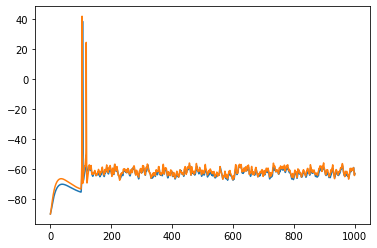

In [12]:
#apply Neuron_Reduce to simplify the cell
reduced_cell, synapses_list, netcons_list, txt = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
for r in randoms_list:r.seq(1) #reset random


#Running the simulation again but now on the reduced cell
st = time.time()
h.run()
print('reduced cell simulation time {:.4f}'.format(time.time()-st))
reduced_celll_v = list(soma_v)

#plotting the results
plt.figure()

plt.plot(time_v, complex_cell_v, label='complex cell')
plt.plot(time_v, reduced_celll_v,  label='reduced cell')
plt.show()

In [13]:
print(txt) #shows how the original segments were mapped to the reduced segments

{'L5PCtemplate[0].apic[0](0.166667)': 'model[0].apic[0](0.000615167)', 'L5PCtemplate[0].apic[0](0.5)': 'model[0].apic[0](0.004276)', 'L5PCtemplate[0].apic[0](0.833333)': 'model[0].apic[0](0.0105102)', 'L5PCtemplate[0].apic[104](0.5)': 'model[0].apic[0](0.0150974)', 'L5PCtemplate[0].apic[106](0.5)': 'model[0].apic[0](0.0184817)', 'L5PCtemplate[0].apic[108](0.5)': 'model[0].apic[0](0.0210916)', 'L5PCtemplate[0].apic[107](0.5)': 'model[0].apic[0](0.0215316)', 'L5PCtemplate[0].apic[105](0.1)': 'model[0].apic[0](0.0173168)', 'L5PCtemplate[0].apic[105](0.3)': 'model[0].apic[0](0.0203796)', 'L5PCtemplate[0].apic[105](0.5)': 'model[0].apic[0](0.0226994)', 'L5PCtemplate[0].apic[105](0.7)': 'model[0].apic[0](0.0242502)', 'L5PCtemplate[0].apic[105](0.9)': 'model[0].apic[0](0.0250269)', 'L5PCtemplate[0].apic[1](0.166667)': 'model[0].apic[0](0.018328)', 'L5PCtemplate[0].apic[1](0.5)': 'model[0].apic[0](0.0314834)', 'L5PCtemplate[0].apic[1](0.833333)': 'model[0].apic[0](0.0439678)', 'L5PCtemplate[0]

In [14]:
# txt.get('L5PCtemplate[0].apic[0](0.166667)')
branching_seg=txt.get('L5PCtemplate[0].apic[36](0.961538)') #shows the reduced segment that the complex nexus branching segment mapped to

In [15]:
branching_seg = branching_seg.replace("[0]", "",1)
print(branching_seg)

model.apic[0](0.289004)


In [16]:
branching_seg="reduced_cell.hoc_"+branching_seg

In [17]:
print(branching_seg)

reduced_cell.hoc_model.apic[0](0.289004)


In [18]:
exec("print(dir("+branching_seg+"))")

['CaDynamics_E2', 'Ca_HVA', 'Ca_LVAst', 'Ih', 'Im', 'NaTa_t', 'SK_E2', 'SKv3_1', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'area', 'ca_ion', 'cm', 'diam', 'k_ion', 'na_ion', 'node_index', 'pas', 'point_processes', 'ri', 'sec', 'v', 'volume', 'x']


In [19]:
sections_to_expand=[reduced_cell.hoc_model.apic[0]] #list of sections to expand
branching_x=0.289004

In [20]:
print(sections_to_expand[0](0.000000000000000001).pas.g)
print(sections_to_expand[0](0.9999999999999999).pas.g)

5.889999999999999e-05
5.89e-05


In [21]:
#change cable params to include parent section
CableParams = collections.namedtuple('CableParams',
                                     'length, diam, space_const,type, furcation_x,type_index'
                                     'cm, rm, ra, e_pas, electrotonic_length,'
                                     )

In [22]:
def apply_params_to_section(name, type_of_sectionlist, instance_as_str, section, cable_params, nseg):
    section.L = cable_params.length
    section.diam = cable_params.diam
    section.nseg = nseg

    append_to_section_lists(name, type_of_sectionlist, instance_as_str)

    section.insert('pas')
    section.cm = cable_params.cm
    section.g_pas = 1.0 / cable_params.rm
    section.Ra = cable_params.ra
    section.e_pas = cable_params.e_pas

In [23]:
#changing reduce_subtree(subtree_root_section) into expand_cylinder(reduced_section)
def expand_cable(section_to_expand, frequency, furcation_x, nbranch):
    '''expand a cylinder (cable) from the reduced_cell into one trunk and nbranch identical branch sections.
    The expansion is done by finding the lengths and diameters of the trunk and branch.
    Trunk length is chosen using the furcation point.
    Trunk diameter is the same as the cable.
    Branch Diameter is chosen using the 3/2 power rule.
    Branch length is chosen so that electrotonic length of the dendritic tree is the same as the cable's electrotonic length.
    '''

    section_to_expand_ref = h.SectionRef(sec=section_to_expand)
    sec_type=section_to_expand.name().split(".")[1][:4] #get section type
    cm, rm, ra, e_pas, q = _get_subtree_biophysical_properties(section_to_expand, frequency)

    # finds the subtree's input impedance (at the somatic-proximal end of the
    # subtree root section) and the lowest transfer impedance in the subtree in
    # relation to the somatic-proximal end (see more in Readme on NeuroReduce)
    imp_obj, root_input_impedance = measure_input_impedance_of_subtree(section_to_expand, frequency)

    # in Ohms (a complex number)
    curr_lowest_subtree_imp = find_lowest_subtree_impedance(section_to_expand_ref, imp_obj)

    # expanding the single cylinder into one trunk and multiple tufts
    trunk_diam = section_to_expand.diam
    trunk_diam_in_cm=trunk_diam/10000
    trunk_Ri = section_to_expand.Ra
    trunk_Rm = 1/section_to_expand(0.5).pas.g
    trunk_L = section_to_expand*furcation_x #since trunk has same Ri,Rm,d electrotonically the same as cable


    branch_diam=(trunk_diam**(3/2)/nbranch)**(2/3) # d(3/2) power rule. solving trunk_d^(3/2)=sum(branch_diam^3/2) for branch diam
    branch_diam_in_cm = branch_diam/10000
    branch_Ri=trunk_Ri
    branch_Rm=trunk_Rm
    # solving cable_elec_L = dend_elec_L = trunk_elec_L + branch_elec_L for branch electrotonic length for one order of branching
    cable_elec_L = calc_elec_length(section_to_expand_ref)
    trunk_elec_L = calc_elec_length(trunk)
    branch_elec_L = cable_elec_L-trunk_elec_L
    # solving elec_L=Length/sqrt((Rm/Ri)*(d/4)) for Length
    branch_L = branch_elec_L*np.sqrt((branch_Rm/branch_Ri)*branch_diam/4)


    # calculating the space constant, in order to find the cylinder's length:
    # space_const = sqrt(rm/(ri+r0))
    trunk_space_const_in_cm = find_space_const_in_cm(trunk_diam_in_cm,
                                                    rm,
                                                    ra)
    trunk_space_const_in_micron = 10000 * trunk_space_const_in_cm

    branch_space_const_in_cm = find_space_const_in_cm(branch_diam_in_cm,
                                                    rm,
                                                    ra)
    branch_space_const_in_micron = 10000 * branch_space_const_in_cm

    print('trunk_diam:',trunk_diam,'|trunk_length:',trunk_L,'|branch_diam:',branch_diam,'|branch_length:',branch_L)
    # len(CableParams)

    return [CableParams(length=trunk_L, #trunk
                       diam=trunk_diam,
                       space_const=trunk_space_const_in_micron,
                       cm=cm,
                       rm=rm,
                       ra=ra,
                       e_pas=e_pas,
                       electrotonic_length=trunk_elec_L,
                       sec_type=sec_type,
                       furcation_x=furcation_x), 
            CableParams(length=branch_L, #branch
                       diam=branch_diam,
                       space_const=branch_space_const_in_micron,
                       cm=cm,
                       rm=rm,
                       ra=ra,
                       e_pas=e_pas,
                       electrotonic_length=branch_elec_L,
                       sec_type=sec_type,
                       furcation_x=furcation_x)]
    
def calc_elec_length(sec):
  '''
  calculates the entire electrotonic length of a section
  elec_L=Length/sqrt((Rm/Ri)*(d/4)) 
  Where Rm is membrane resistance time unit area (in ohms*(cm)^2) 
  and Ri is specific intracellular resisitivity (ohms*cm).
  '''
  d=sec.diam*10000 #convert microns (10**-6) to cm (10**-2)
  elec_L=sec.L/np.sqrt((sec(0.5).pas.g/sec.Ra)*(d/4))
  return elec_L

In [24]:
#changing create_reduced_cell into create_dendritic_cell
def create_dendritic_cell(soma_cable,
                        has_apical,
                        original_cell,
                        model_obj_name,
                        trunk_cable_properties, branch_cable_properties, nbranches,sections_to_expand,sections_to_keep, #new_cable_properties,  #lists for each expansion
                        trunk_nsegs, branch_nsegs, #new_cables_nsegs,
                        subtrees_xs):
    h("objref reduced_dendritic_cell")
    h("reduced_dendritic_cell = new " + model_obj_name + "()")

    create_sections_in_hoc("soma", 1, "reduced_dendritic_cell")

    soma = original_cell.soma[0] if original_cell.soma.hname()[-1] == ']' else original_cell.soma
    append_to_section_lists("soma[0]", "somatic", "reduced_dendritic_cell")
    sec_type_list=[]
    trunk_sec_type_list = []
    kept_sec_type_list = []
    apicals=[]
    basals=[]
    all_sections=[]
    #get original_cell type list lengths
    # 
    # get 
    for i,sec in enumerate(sections_to_expand):
      sec_type=sec.name().split(".")[1][:4] #get section type
      # sec_index_for_type=sec.name().split("[")[2].split("]")[0] # get the index for the section within the section type list
      sec_type_list.append(sec_type) #append trunk sec_type 
      trunk_sec_type_list.append(sec_type) #append trunk sec_type to its own list
      #include branches
      for nbranch in nbranches:
        for i in range(nbranch):
          sec_type_list.append(sec_type) # append branches sec_type (same as trunk)


    for i,sec in enumerate(sections_to_keep):
      sec_type=sec.name().split(".")[1][:4] #get section type
      # sec_index_for_type=sec.name().split("[")[2].split("]")[0] # get the index for the section within the section type list
      sec_type_list.append(sec_type)
      kept_sec_type_list.append(sec_type)


    #create section lists with the total number of sections for each section type
    for unique_sec_type in sec_type_list.unique():
      num_sec_type_for_this_unique_sec_type=sec_type_list.count(unique_sec_type)
      create_sections_in_hoc(unique_sec_type,num_sec_type_for_this_unique_sec_type,"reduced_dendritic_cell")

      if unique_sec_type=='apic':
        apicals = [h.reduced_cell.apic[i] for i in range(num_sec_type_for_this_unique_sec_type)]
      elif unique_sec_type == 'dend':
        basals = [h.reduced_cell.dend[i] for i in range(num_sec_type_for_this_unique_sec_type)]
      else:
        print('error: sec_type', sec_type,' is not "apic" or "dend"')

        # for i in range(sec_type_list):
        #   new_section=h.reduced_cell.getattr(sec_type)[i]

    #assemble tree sections
    number_of_sections_in_apical_list=0 # count as we add sections since cannot do len(h.reduced_cell.apical)
    number_of_sections_in_basal_list=0
    trunk_sec_type_list_indices=[]
    for i in range(trunk_cable_properties):
        trunk_cable_params = trunk_cable_properties[i]
        branch_cable_params = branch_cable_properties[i]
        trunk_nseg = trunk_nsegs[i]
        branch_nseg = branch_nsegs[i]
        nbranch=nbranches[i]
        trunk_sec_type=trunk_sec_type_list[i]

        if trunk_sec_type=='dend': # basal 
          #trunk
          trunk_index=number_of_sections_in_basal_list # trunk index of basal list
          trunk_cable_params.sec_index_for_type=trunk_index
          print('test: trunk_cable_params.sec_index_for_type:',trunk_cable_params.sec_index_for_type) #check is this works
          apply_params_to_section("dend"+"[" + str(trunk_index) + "]", "basal", "reduced_cell",  #apply params to trunk
                                basals[trunk_index], trunk_cable_params, trunk_nseg)
          basals[trunk_index].connect(soma, subtrees_xs[i], 0) #connect trunk to soma where it was previously connected
          trunk_sec_type_list_indices.append(trunk_index) #get list of trunk indices for trunk's respective sec_type_list (apic or dend)
          number_of_basal_sections_in_basal_list+=1
          #branches
          for j in range(nbranch): #apply branch parameters to next nbranch sections
                    branch_index=number_of_sections_in_apical_list
                    apply_params_to_section("dend"+"[" + str(branch_index) + "]", "basal", "reduced_cell",  #apply params to branch
                                basals[branch_index], branch_cable_params, branch_nseg)
                    basals[branch_index].connect(basals[trunk_index], 1, 0) # connect branch to distal end of trunk
                    number_of_sections_in_basal_list+=1

        elif trunk_sec_type=='apic': # apical
          #trunk
          trunk_index=number_of_sections_in_apical_list
          apply_params_to_section("apic"+"[" + str(trunk_index) + "]", "apical", "reduced_cell",  #apply params to trunk
                                apicals[trunk_index], trunk_cable_params, trunk_nseg)
          apicals[trunk_index].connect(soma, subtrees_xs[i], 0) #connect trunk to soma where it was previously connected
          trunk_sec_type_list_indices.append(trunk_index) #get list of trunk indices for trunk's respective sec_type_list (apic or dend)
          number_of_sections_in_apical_list+=1
          #branches
          for j in range(nbranch): #apply branch parameters to next nbranch sections
                    branch_index=number_of_sections_in_apical_list
                    apply_params_to_section("apic"+"[" + str(branch_index) + "]", "apical", "reduced_cell", #apply params to branch
                                apicals[branch_index], branch_cable_params, branch_nseg)
                    apicals[branch_index].connect(apicals[trunk_index], 1, 0) # connect branch to distal end of trunk
                    number_of_sections_in_apical_list+=1

        else:
          raise(trunk_sec_type,'is not "apic" or "dend"')
    for i in range(sections_to_keep): #add kept sections to the section lists
      if kept_sec_type_list[i]=='apic':
        sec_index=number_of_sections_in_apical_list
        append_to_section_lists("apic"+"[" + str(sec_index) + "]", "apical", "reduced_cell")
        number_of_sections_in_apical_list+=1
      elif kept_sec_type_list[i]=='dend':
        sec_index=number_of_sections_in_basal_list
        append_to_section_lists("dend"+"[" + str(sec_index) + "]", "basal", "reduced_cell")
        number_of_sections_in_basal_list+=1
      else:
        raise(kept_sec_type_list[i],'is not "apic" or "dend"')

    # create cell python template
    cell = Neuron(h.reduced_cell)
    cell.soma = original_cell.soma
    # cell.apic = apic

    return cell, basals, apicals, trunk_sec_type_list_indices

In [25]:
def find_and_disconnect_sections_to_keep(soma_ref,sections_to_expand):
    '''Searching for sections to keep, they can be a child of the soma or a parent of the soma.'''
    sections_to_keep, is_section_to_keep_soma_parent, soma_sections_to_keep_x  = [], [], []
    for sec in soma_ref.child:
        # name = sec.hname().lower()
        if sec not in sections_to_expand:
            sections_to_keep.append(sec)
            is_section_to_keep_soma_parent.append(False)
            # disconnect section
            soma_sections_to_keep_x.append(sec.parentseg().x)
            sec.push()
            h.disconnect()
            h.define_shape()

    if soma_ref.has_parent():
            sections_to_keep.append(soma_ref.parent())
            is_section_to_keep_soma_parent.append(True)
            soma_sections_to_keep_x.append(None)
            soma_ref.push()
            h.disconnect()
    else:
        raise Exception('Soma has a parent which is not an axon')

    return sections_to_keep, is_section_to_keep_soma_parent, soma_sections_to_keep_x

In [26]:
def gather_cell_subtrees(roots_of_subtrees):
    # dict that maps section indexes to the subtree index they are in: keys are
    # string tuples: ("apic"/"basal", orig_section_index) , values are ints:
    # subtree_instance_index
    sections_to_delete = []
    section_per_subtree_index = {}
    mapping_sections_to_subtree_index = {}
    for i, soma_child in enumerate(roots_of_subtrees):
        # inserts each section in this subtree into the above dict, which maps
        # it to the subtree index
        if 'apic' in soma_child.hname():
            assert i == 0, ('The apical is not the first child of the soma! '
                            'a code refactoring is needed in order to accept it')
            mark_subtree_sections_with_subtree_index(sections_to_delete,
                                                     section_per_subtree_index,
                                                     soma_child,
                                                     mapping_sections_to_subtree_index,
                                                     "apic",
                                                     i)
        elif 'dend' in soma_child.hname() or 'basal' in soma_child.hname():
            mark_subtree_sections_with_subtree_index(sections_to_delete,
                                                     section_per_subtree_index,
                                                     soma_child,
                                                     mapping_sections_to_subtree_index,
                                                     "basal",
                                                     i)

    return sections_to_delete, section_per_subtree_index, mapping_sections_to_subtree_index

In [27]:
def expand_synapse(cell_instance,
                   synapse_location,
                   on_basal,
                   imp_obj,
                   root_input_impedance,
                   trunk_properties,branch_properties,furcation_x,
                   q_subtree):
    '''
    Receives an instance of a cell, the location (section + relative
    location(x)) of a synapse to be reduced, a boolean on_basal that is True if
    the synapse is on a basal subtree, the number of segments in the reduced
    cable that this synapse is in, an Impedance calculating Hoc object, the
    input impedance at the root of this subtree, and the electrotonic length of
    the reduced cable that represents the current subtree
    (as a real and as a complex number) -
    and maps the given synapse to its new location on the reduced cable
    according to the NeuroReduce algorithm.  Returns the new "post-merging"
    relative location of the synapse on the reduced cable (x, 0<=x<=1), that
    represents the middle of the segment that this synapse is located at in the
    new reduced cable.
    '''
    # measures the original transfer impedance from the synapse to the
    # somatic-proximal end in the subtree root section
    if not on_basal:  # apical subtree
        section = cell_instance.apic[synapse_location.section_num]
    else:             # basal subtree
        section = cell_instance.dend[synapse_location.section_num]

    with push_section(section):
        orig_transfer_imp = imp_obj.transfer(synapse_location.x) * 1000000  # ohms
        orig_transfer_phase = imp_obj.transfer_phase(synapse_location.x)
        # creates a complex Impedance value with the given polar coordinates
        orig_synapse_transfer_impedance = cmath.rect(orig_transfer_imp, orig_transfer_phase)

    # synapse location could be calculated using:
    # X = L - (1/q) * arcosh( (Zx,0(f) / ZtreeIn(f)) * cosh(q*L) ),
    # derived from Rall's cable theory for dendrites (Gal Eliraz)
    # but we chose to find the X that will give the correct modulus. See comment about L values

    elec_L_dend=trunk_properties.electrotonic_length+branch_properties.electrotonic_length


    synapse_new_electrotonic_location = find_best_real_X(root_input_impedance,
                                                         orig_synapse_transfer_impedance,
                                                         q_subtree,
                                                         new_cable_electrotonic_length=elec_L_dend)
                                                         
    #relative location along entire dendrite                                                     
    new_relative_loc_in_section = (float(synapse_new_electrotonic_location) /
                                   elec_L_dend)
    #determine x loc is  trunk or branch
    if new_relative_loc_in_section<furcation_x: #trunk
      on_trunk=True
      new_relative_loc_in_section = new_relative_loc_in_section/furcation_x #adjust for section x loc
    else: #branch case
      on_trunk=False
      branch_elec_L_for_synapse = synapse_new_electrotonic_location-trunk_properties.electrotonic_length
      # solve branch_elec_L_for_synapse = branch_syn_L/branch_space_const for branch_syn_L (the length up the branch to the synapses electrotonic length)
      branch_L_for_synapse = branch_elec_L_for_synapse*branch_properties.space_constant
      # find proportionate length for x doing L_syn/L_branch
      new_relative_loc_in_section = branch_L_for_synapse/branch_properties.length

    if new_relative_loc_in_section > 1:  # PATCH
        new_relative_loc_in_section = 0.999999

    return new_relative_loc_in_section, on_trunk

def find_branch_synapse_X(cell_instance,
                   synapse_location,
                   on_basal,
                   imp_obj,
                   root_input_impedance,
                   new_cable_electrotonic_length,
                   q_subtree,
                   trunk_properties, branch_properties):
    '''
    Receives an instance of a cell, the location (section + relative
    location(x)) of a synapse to be reduced, a boolean on_basal that is True if
    the synapse is on a basal subtree, the number of segments in the reduced
    cable that this synapse is in, an Impedance calculating Hoc object, the
    input impedance at the root of this subtree, and the electrotonic length of
    the reduced cable that represents the current subtree
    (as a real and as a complex number) -
    and maps the given synapse to its new location on the reduced cable
    according to the NeuroReduce algorithm.  Returns the new "post-merging"-
    relative location of the synapse on the reduced cable (x, 0<=x<=1), that
    represents the middle of the segment that this synapse is located at in the
    new reduced cable.
    '''
    # measures the original transfer impedance from the synapse to the
    # somatic-proximal end in the subtree root section
    if not on_basal:  # apical subtree
        section = cell_instance.apic[synapse_location.section_num]
    else:             # basal subtree
        section = cell_instance.dend[synapse_location.section_num]

    with push_section(section):
        orig_transfer_imp = imp_obj.transfer(synapse_location.x) * 1000000  # ohms
        orig_transfer_phase = imp_obj.transfer_phase(synapse_location.x)
        # creates a complex Impedance value with the given polar coordinates
        orig_synapse_transfer_impedance = cmath.rect(orig_transfer_imp, orig_transfer_phase)

    # synapse location could be calculated using:
    # X = L - (1/q) * arcosh( (Zx,0(f) / ZtreeIn(f)) * cosh(q*L) ),
    # derived from Rall's cable theory for dendrites (Gal Eliraz)
    # but we chose to find the X that will give the correct modulus. See comment about L values

    synapse_new_electrotonic_location = find_best_real_X(root_input_impedance,
                                                         orig_synapse_transfer_impedance,
                                                         q_subtree,
                                                         new_cable_electrotonic_length)
    #solve syn_elec_L=trunk_elec_L+branch_elec_L for branch_elec_L
    branch_elec_L_for_synapse = synapse_new_electrotonic_location-trunk_properties.electrotonic_length
    # solve branch_elec_L_for_synapse = branch_syn_L/branch_space_const for branch_syn_L (the length up the branch to the synapses electrotonic length)
    branch_L_for_synapse = branch_elec_L_for_synapse*branch_properties.space_constant
    # find proportionate length for x doing L_syn/L_branch
    new_relative_loc_in_section = branch_L_for_synapse/branch_properties.length

    if new_relative_loc_in_section > 1:  # PATCH
        new_relative_loc_in_section = 0.999999

    return new_relative_loc_in_section

In [28]:
def adjust_new_tree_synapses(num_sections_to_expand,
                           trunk_properties, branch_properties, nbranches, furcations_x, all_trunk_sec_type, trunk_sec_type_list_indices, #list of indices for dend[], apic[] of trunk sections
                           PP_params_dict,
                           synapses_list,
                           mapping_sections_to_subtree_index,
                           netcons_list,
                           has_apical,
                           sections_to_expand,
                           original_cell,
                           basals, apicals,
                           cell,
                           reduction_frequency):
    # dividing the original synapses into baskets, so that all synapses that are
    # on the same subtree will be together in the same basket

    # a list of baskets of synapses, each basket in the list will hold the
    # synapses of the subtree of the corresponding basket index
    baskets = [[] for _ in sections_to_expand]
    soma_synapses_syn_to_netcon = {}

    new_synapses_list, subtree_ind_to_q = [], {}

    for syn_index, synapse in enumerate(synapses_list):
      if synapse.sec in sections_to_expand:
        synapse_location = find_synapse_loc(synapse, mapping_sections_to_subtree_index)

        # for a somatic synapse
        # TODO: 'axon' is never returned by find_synapse_loc...
        if synapse_location.subtree_index in (SOMA_LABEL, 'axon'):
            soma_synapses_syn_to_netcon[synapse] = netcons_list[syn_index]
        else:
            baskets[synapse_location.subtree_index].append((synapse, synapse_location, syn_index))
      else: #leave synapses not on new trees synapses alone
        new_synapses_list.append(synapse)

    # mapping (non-somatic) synapses to their new location on the reduced model
    # (the new location is the exact location of the middle of the segment they
    # were mapped to, in order to enable merging)
    for section_to_expand_index in len(sections_to_expand):
        imp_obj, subtree_input_impedance = measure_input_impedance_of_subtree(
            sections_to_expand[section_to_expand_index], reduction_frequency)
        subtree_ind_to_q[section_to_expand_index] = calculate_subtree_q(
            sections_to_expand[section_to_expand_index], reduction_frequency)
        
        trunk_index = trunk_sec_type_list_indices[section_to_expand_index]
        x_furcation = furcations_x[section_to_expand_index]
        # iterates over the synapses in the curr basket
        for synapse, synapse_location, syn_index in baskets[section_to_expand_index]:
            # get trunk synapses
            if synapse.x < x_furcation: #synapse proximal to furcation point is on trunk
              #locate this trunk section
              if all_trunk_sec_type[section_to_expand_index]=='dend':
                section_for_synapse = basals[trunk_index] #get the trunk section
              elif all_trunk_sec_type[section_to_expand_index]=='apic':
                section_for_synapse = apicals[trunk_index]
              else:
                raise(all_trunk_sec_type[section_to_expand_index],' is not "apic" or "dend"')
              #adjust x location since trunk is fraction of cable length
              x = synapse.x/x_furcation
            else: #synapse is distal to furcation meaning on branch
              nbranch=nbranches[section_to_expand_index] # number of branches on this tree
              branch_index=trunk_index+np.random.uniform(1,nbranch) #select random branch on this tree to move synapse to
              if all_trunk_sec_type[section_to_expand_index]=='dend':
                section_for_synapse = basals[branch_index]
              elif all_trunk_sec_type[section_to_expand_index]=='apic':
                section_for_synapse = apicals[branch_index]
              else:
                raise(all_trunk_sec_type[section_to_expand_index],' is not "apic" or "dend"')
              
              #adjust x location to the point on the branch that has the same electrotonic length as originally

              dend_elec_L=trunk_properties[section_to_expand_index].electrotonic_length+branch_properties[section_to_expand_index]
              on_basal_subtree = not (has_apical and section_to_expand_index == 0)
              x = find_branch_synapse_X(original_cell,
                   synapse_location,
                   on_basal_subtree,
                   imp_obj,
                   subtree_input_impedance,
                   dend_elec_L,
                   subtree_ind_to_q[section_to_expand_index],
                   trunk_properties=trunk_properties[section_to_expand_index], branch_properties=branch_properties[section_to_expand_index])
              

            # go over all point processes in this segment and see whether one
            # of them has the same proporties of this synapse
            # If there's such a synapse link the original NetCon with this point processes
            # If not, move the synapse to this segment.
            for PP in section_for_synapse(x).point_processes():
                if type_of_point_process(PP) not in PP_params_dict:
                    add_PP_properties_to_dict(PP, PP_params_dict)

                if synapse_properties_match(synapse, PP, PP_params_dict):
                    netcons_list[syn_index].setpost(PP)
                    break
            else:  # If for finish the loop -> first appearance of this synapse
                synapse.loc(x, sec=section_for_synapse)
                new_synapses_list.append(synapse)

    # merging somatic and axonal synapses
    synapses_per_seg = collections.defaultdict(list)
    for synapse in soma_synapses_syn_to_netcon:
        seg_pointer = synapse.get_segment()

        for PP in synapses_per_seg[seg_pointer]:
            if type_of_point_process(PP) not in PP_params_dict:
                add_PP_properties_to_dict(PP, PP_params_dict)

            if synapse_properties_match(synapse, PP, PP_params_dict):
                soma_synapses_syn_to_netcon[synapse].setpost(PP)
                break
        else:  # If for finish the loop -> first appearance of this synapse
            synapse.loc(seg_pointer.x, sec=seg_pointer.sec)
            new_synapses_list.append(synapse)
            synapses_per_seg[seg_pointer].append(synapse)

    return new_synapses_list, subtree_ind_to_q

In [29]:
def create_seg_to_seg(original_cell,
                      section_per_subtree_index,
                      sections_to_expand,
                      mapping_sections_to_subtree_index,
                      all_trunk_properties, all_branch_properties,
                      has_apical,
                      apicals,
                      basals,
                      subtree_ind_to_q,
                      mapping_type,
                      reduction_frequency):
    '''create mapping between segments in the original model to segments in the reduced model
       if mapping_type == impedance the mapping will be a response to the
       transfer impedance of each segment to the soma (like the synapses)
       if mapping_type == distance  the mapping will be a response to the
       distance of each segment to the soma (like the synapses) NOT IMPLEMENTED
       YET
       '''

    assert mapping_type == 'impedance', 'distance mapping not implemented yet'
    # the keys are the segments of the original model, the values are the
    # segments of the reduced model
    original_seg_to_reduced_seg = {}
    reduced_seg_to_original_seg = collections.defaultdict(list)
    for subtree_index in section_per_subtree_index:
        for sec in section_per_subtree_index[subtree_index]:
            for seg in sec:
                synapse_location = find_synapse_loc(seg, mapping_sections_to_subtree_index)
                imp_obj, subtree_input_impedance = measure_input_impedance_of_subtree(
                    sections_to_expand[subtree_index], reduction_frequency)

                # if synapse is on the apical subtree
                on_basal_subtree = not (has_apical and subtree_index == 0)

                mid_of_segment_loc, on_trunk = expand_synapse(
                    original_cell,
                    synapse_location,
                    on_basal_subtree,
                    imp_obj,
                    subtree_input_impedance,
                    all_trunk_properties[subtree_index], all_branch_properties[subtree_index],
                    subtree_ind_to_q[subtree_index])

                if on_basal_subtree:
                    if has_apical:
                        new_section_for_synapse = basals[subtree_index - 1]
                    else:
                        new_section_for_synapse = basals[subtree_index]
                else:
                    new_section_for_synapse = apicals[0]

                reduced_seg = new_section_for_synapse(mid_of_segment_loc)
                original_seg_to_reduced_seg[seg] = reduced_seg
                reduced_seg_to_original_seg[reduced_seg].append(seg)

    return original_seg_to_reduced_seg, dict(reduced_seg_to_original_seg)

In [30]:
def cable_expander(original_cell,
                     sections_to_expand_list, 
                     furcations_x, 
                     nbranches,
                     synapses_list,
                     netcons_list,
                     reduction_frequency,
                     model_filename='model.hoc',
                     total_segments_manual=-1,
                     PP_params_dict=None,
                     mapping_type='impedance',
                     return_seg_to_seg=False,
                     ):

    '''
    Receives an instance of a cell with a loaded full morphology, a list of
    synapse objects, a list of NetCon objects (the i'th netcon in the list
    should correspond to the i'th synapse), the filename (string) of the model
    template hoc file that the cell was instantiated from, the desired
    reduction frequency as a float, optional parameter for the approximate
    desired number of segments in the new model (if this parameter is empty,
    the number of segments will be such that there is a segment for every 0.1
    lambda), and an optional param for the point process to be compared before
    deciding on whether to merge a synapse or not and reduces the cell (using
    the given reduction_frequency). Creates a reduced instance using the model
    template in the file whose filename is given as a parameter, and merges
    synapses of the same type that get mapped to the same segment
    (same "reduced" synapse object for them all, but different NetCon objects).
    model_filename : model.hoc  will use a default template
    total_segments_manual: sets the number of segments in the reduced model
                           can be either -1, a float between 0 to 1, or an int
                           if total_segments_manual = -1 will do automatic segmentation
                           if total_segments_manual>1 will set the number of segments
                           in the reduced model to total_segments_manual
                           if 0>total_segments_manual>1 will automatically segment the model
                           but if the automatic segmentation will produce a segment number that
                           is lower than original_number_of_segments*total_segments_manual it
                           will set the number of segments in the reduced model to:
                           original_number_of_segments*total_segments_manual
    return_seg_to_seg: if True the function will also return a textify version of the mapping
                       between the original segments to the reduced segments 
    Returns the new reduced cell, a list of the new synapses, and the list of
    the inputted netcons which now have connections with the new synapses.
    Notes:
    1) The original cell instance, synapses and Netcons given as arguments are altered
    by the function and cannot be used outside of it in their original context.
    2) Synapses are determined to be of the same type and mergeable if their reverse
    potential, tau1 and tau2 values are identical.
    3) Merged synapses are assigned a single new synapse object that represents them
    all, but keep their original NetCon objects. Each such NetCon now connects the
    original synapse's NetStim with
    the reduced synapse.
    '''
    for nbranch in nbranches:
      if type(nbranch) is not int:
        raise TypeError('nbranches must be array of int')

    if PP_params_dict is None:
        PP_params_dict = {}

    h.init()

    model_obj_name = load_model(model_filename)

    # finds soma properties
    soma = original_cell.soma[0] if original_cell.soma.hname()[-1] == ']' else original_cell.soma

    soma_cable = CableParams(length=soma.L, diam=soma.diam, space_const=None,
                             cm=soma.cm, rm=1.0 / soma.g_pas, ra=soma.Ra, e_pas=soma.e_pas,
                             electrotonic_length=None,sec_type='soma',furcation_x=None,)

    has_apical = len(list(original_cell.apical)) != 0

    soma_ref = h.SectionRef(sec=soma)
    sections_to_keep, is_section_to_keep_soma_parent, soma_sections_to_keep_x = find_and_disconnect_sections_to_keep(soma_ref,sections_to_expand)
#     roots_of_subtrees, num_of_subtrees = gather_subtrees(soma_ref)
# # ************************************stopping point today*********************************
    sections_to_delete, section_per_subtree_index, mapping_sections_to_subtree_index = \
        gather_cell_subtrees(sections_to_expand)


    # preparing for expansion

    # remove active conductances and get seg_to_mech dictionary
    segment_to_mech_vals=create_segments_to_mech_vals(sections_to_expand) ######################################***************** Check

    # disconnects all the sections_to_expand from the soma
    subtrees_xs = []
    for section_to_expand in sections_to_expand:
        subtrees_xs.append(section_to_expand.parentseg().x)
        h.disconnect(sec=section_to_expand)

    # expanding the subtrees
    all_trunk_properties=[] #list of all trunk cable properties
    all_branch_properties=[] #list of all branch cable properties
    for i,sec in enumerate(sections_to_expand):
      trunk_properties,branch_properties=expand_cable(sections_to_expand[i], reduction_frequency, furcations_x[i], nbranches[i])
      all_trunk_properties.append(trunk_properties)
      all_branch_properties.append(branch_properties)
      trunk_nsegs = calculate_nsegs_from_lambda(trunk_properties)
      branch_nsegs = calculate_nsegs_from_lambda(trunk_properties) * nbranches

    # trunk_properties,branch_properties = [expand_cable(sections_to_expand[i], reduction_frequency, furcations_x, nbranches)
    #                         for i in sections_to_expand]

    # if total_segments_manual > 1:
    #     new_cables_nsegs = calculate_nsegs_from_manual_arg(new_cable_properties,
    #                                                        total_segments_manual)
    # else:
    #     new_cables_nsegs = calculate_nsegs_from_lambda(new_cable_properties)
    #     if total_segments_manual > 0:
    #         original_cell_seg_n = (sum(i.nseg for i in list(original_cell.basal)) +
    #                                sum(i.nseg for i in list(original_cell.apical))
    #                                )
    #         min_reduced_seg_n = int(round((total_segments_manual * original_cell_seg_n)))
    #         if sum(new_cables_nsegs) < min_reduced_seg_n:
    #             logger.debug("number of segments calculated using lambda is {}, "
    #                   "the original cell had {} segments.  "
    #                   "The min reduced segments is set to {}% of reduced cell segments".format(
    #                       sum(new_cables_nsegs),
    #                       original_cell_seg_n,
    #                       total_segments_manual * 100))
    #             logger.debug("the reduced cell nseg is set to %s" % min_reduced_seg_n)
    #             new_cables_nsegs = calculate_nsegs_from_manual_arg(new_cable_properties,
    #                                                                min_reduced_seg_n)
                

    cell, basals, apicals, trunk_sec_type_list_indices = create_dendritic_cell(soma_cable,
                                                                                has_apical,
                                                                                original_cell,
                                                                                model_obj_name,
                                                                                all_trunk_properties, all_branch_properties, nbranches,
                                                                                sections_to_expand,sections_to_keep, #new_cable_properties,  #lists for each expansion
                                                                                trunk_nsegs, branch_nsegs, #new_cables_nsegs,
                                                                                subtrees_xs)

    new_synapses_list, subtree_ind_to_q = adjust_new_tree_synapses(
        len(sections_to_expand),
        all_trunk_properties, all_branch_properties,
        PP_params_dict,
        synapses_list,
        mapping_sections_to_subtree_index,
        netcons_list,
        has_apical,
        sections_to_expand,
        original_cell,
        basals,
        cell,
        reduction_frequency)


    # create segment to segment mapping
    original_seg_to_reduced_seg, reduced_seg_to_original_seg = create_seg_to_seg(
        original_cell,
        section_per_subtree_index,
        sections_to_expand,
        mapping_sections_to_subtree_index,
        all_trunk_properties, all_branch_properties,
        has_apical,
        apicals,
        basals,
        subtree_ind_to_q,
        mapping_type,
        reduction_frequency)

    # copy active mechanisms
    copy_dendritic_mech(original_seg_to_reduced_seg,
                        reduced_seg_to_original_seg,
                        cell.apic,
                        basals,
                        segment_to_mech_vals,
                        mapping_type)
    
    if return_seg_to_seg:
        original_seg_to_reduced_seg_text = textify_seg_to_seg(original_seg_to_reduced_seg)

    # Connect disconnected sections back to the soma
    if len(sections_to_keep) > 0:
      for i,sec in enumerate(sections_to_keep):
        if is_section_to_keep_soma_parent[i]:
            soma.connect(sec)
        else:
            sections_to_keep[i].connect(soma, soma_sections_to_keep_x)

    # Now we delete the original model
    for section in sections_to_expand:
        with push_section(section):
            h.delete_section()
    
    #now we add the sections to our list
    if cell.hoc_model.axon is not None:
      cell.axon = cell.hoc_model.axon # cell.axon = axon_section
    if cell.hoc_model.dend is not None:
      cell.dend = cell.hoc_model.dend
    if cell.hoc_model.apic is not None:
      cell.apic = cell.hoc_model.apic

    # # now we add the kept sections to our list
    # for i,sec in enumerate(sections_to_keep:
    #   sec_type=sec.name().split(".")[1][:4]
    #   cell.getattr(sec_type)[].append(sec) #might not work

    with push_section(cell.hoc_model.soma[0]):
        h.delete_section()
    if return_seg_to_seg:
        return cell, new_synapses_list, netcons_list, original_seg_to_reduced_seg_text
    else:
        return cell, new_synapses_list, netcons_list


In [ ]:
################### user specs: ###############
sections_to_expand=[reduced_cell.hoc_model.apic[0]] # list of sections to expand
furcations_x=[0.289004] # list of x loc branching points corresponding to above list
nbranches=[4] #list of desired number of branches for each furcation point
################################################

reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_cell.hoc_model, sections_to_expand, furcations_x, nbranches, 
                                                                          synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

NEURON: section in the object was deleted
 near line 0
 {dend[7] all.append()}
                       

In [ ]:
for i in range(5):
  print(i)

In [ ]:
# extract mechanisms from deleted segments
for seg in reduced_cell.hoc_model.apic[0]:
  # print(seg)
  for mech in seg:
    print(mech)

In [ ]:
#this segment is then centered this far from the soma
reduced_nexus_dist=0.289004*2424.182421257107 # length of apical cylinder * x loc from above
print(reduced_nexus_dist)

In [ ]:
# shorten apical cylinder to nexus branching point.
# print(reduced_cell.hoc_model.apic[0].L)
# reduced_cell.hoc_model.apic[0].L=reduced_nexus_dist
# print(reduced_cell.hoc_model.apic[0].L)

In [ ]:
dir(reduced_cell.hoc_model.apic[0])

In [ ]:
# dir(txt)

In [ ]:
# for key, value in txt.items():
#     print("{:<10}".format(value))

#Show Complex and Reduced Cell

# Citation
O. Amsalem, G. Eyal, N. Rogozinski, M. Gevaert, P. Kumbhar, F. Schürmann, I. Segev. An efficient analytical reduction of detailed nonlinear neuron models. Nat. Commun., 11 (2020), p. 288